In [6]:
from ultralytics import YOLO
from PIL import Image, ImageDraw 
import cv2 
import numpy as np
import torch
from torchvision.transforms import InterpolationMode, transforms
import timm
from IPython.display import display

# Define classes
txt_animalclasses = {
    'en': ["badger", "ibex", "red deer", "chamois", "cat", "goat", "roe deer", "dog", "squirrel", "equid", "genet",
           "hedgehog", "lagomorph", "wolf", "lynx", "marmot", "micromammal", "mouflon",
           "sheep", "mustelid", "bird", "bear", "nutria", "fox", "wild boar", "cow"],
}


In [7]:
class Detector:
    def __init__(self):
        self.model = YOLO('../deepfaune-yolov8s_960.pt')

    def bestBoxDetection(self, imagecv):
        image_rgb = cv2.cvtColor(imagecv, cv2.COLOR_BGR2RGB)
        image_pil = Image.fromarray(image_rgb)
        resized_image = image_pil.resize((960, 960), Image.Resampling.LANCZOS)
        results = self.model(resized_image)

        if not results or not results[0].boxes or results[0].boxes.data.shape[0] == 0:
            return None, 0, np.zeros(4), 0, None

        detections = results[0].boxes.data
        best_detection = detections[detections[:, 4].argmax()]
        xmin, ymin, xmax, ymax, conf, cls_id = best_detection[:6]
        box = [int(xmin), int(ymin), int(xmax), int(ymax)]
        cropped_image = resized_image.crop(box)
        return cropped_image, int(cls_id), box, conf, None

In [8]:
class Classifier:
    def __init__(self, device):
        self.model = self.load_model('../deepfaune-vit_large_patch14_dinov2.lvd142m.pt', device)
        self.transforms = transforms.Compose([
            transforms.Resize((182, 182), interpolation=InterpolationMode.BICUBIC),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def load_model(self, model_path, device):
        model = timm.create_model('vit_large_patch14_dinov2', pretrained=False, num_classes=len(txt_animalclasses['en']), dynamic_img_size=True)
        state_dict = torch.load(model_path, map_location=torch.device(device))['state_dict']
        adjusted_state_dict = {k.replace('base_model.', ''): v for k, v in state_dict.items() if 'base_model.' in k}
        model.load_state_dict(adjusted_state_dict)
        return model

    def predict(self, image):
        img_tensor = self.transforms(image).unsqueeze(0)
        with torch.no_grad():
            output = self.model(img_tensor)
            probabilities = torch.nn.functional.softmax(output, dim=1)
            top_p, top_class = probabilities.topk(1, dim=1)
            return txt_animalclasses['en'][top_class.item()], top_p.item()



0: 960x960 1 animal, 28.1ms
Speed: 2.7ms preprocess, 28.1ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)
cuda: Detection with confidence 0.964, Classification of lynx with confidence 0.999


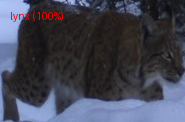

In [14]:
def visualize_detection(cropped_image, label, confidence):
    draw = ImageDraw.Draw(cropped_image)
    text = f"{label} ({confidence*100:.0f}%)"
    draw.text((10, 10), text, fill="red")
    display(cropped_image)

def process_single_image(image_path):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    image = Image.open(image_path)
    imagecv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    detector = Detector()
    classifier = Classifier(device)
    cropped_image, category, box, conf, _ = detector.bestBoxDetection(imagecv)

    if cropped_image is not None:
        animal_type, confidence = classifier.predict(cropped_image)
        print(f"{device}: Detection with confidence {conf:.3f}, Classification of {animal_type} with confidence {confidence:.3f}")
        visualize_detection(cropped_image, animal_type, confidence)
    else:
        print("No object detected.")

current_image_path = "/home/tom-ratsakatika/VSCode/camera-traps/data/raw/Season1 - animals only/POST 17/DOSUL PIETREI_Cuddeback_CC0146_FCC-CAM-057/L__03492.JPG"

process_single_image(current_image_path)


In [10]:
!nvidia-smi

Wed May  8 11:59:00 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.171.04             Driver Version: 535.171.04   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3050 ...    Off | 00000000:01:00.0 Off |                  N/A |
| N/A   53C    P0              19W /  35W |   1531MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--